In [ ]:
import sys
import keras
import sklearn
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import sklearn.preprocessing
from scipy.stats import zscore
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_file, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

import sklearn.metrics as metrics

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/IoT/Cat_OverSample_Smote.csv')
df.head()

,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,...,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat
0,75,1,1,982.0,1430.0,982.0,982.0,982.0,0.000000,1430.0,...,0.0,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,1,1
1,5310,1,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,1,3
2,141,0,3,0.0,2806.0,0.0,0.0,0.0,0.000000,1388.0,...,0.0,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,1,2
3,151,0,2,0.0,2776.0,0.0,0.0,0.0,0.000000,1388.0,...,0.0,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,1,1
4,153,2,1,886.0,420.0,452.0,434.0,443.0,12.727922,420.0,...,0.0,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,1,1


In [ ]:
df.isnull().values.any()

False

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.savefig('1')
    plt.show()

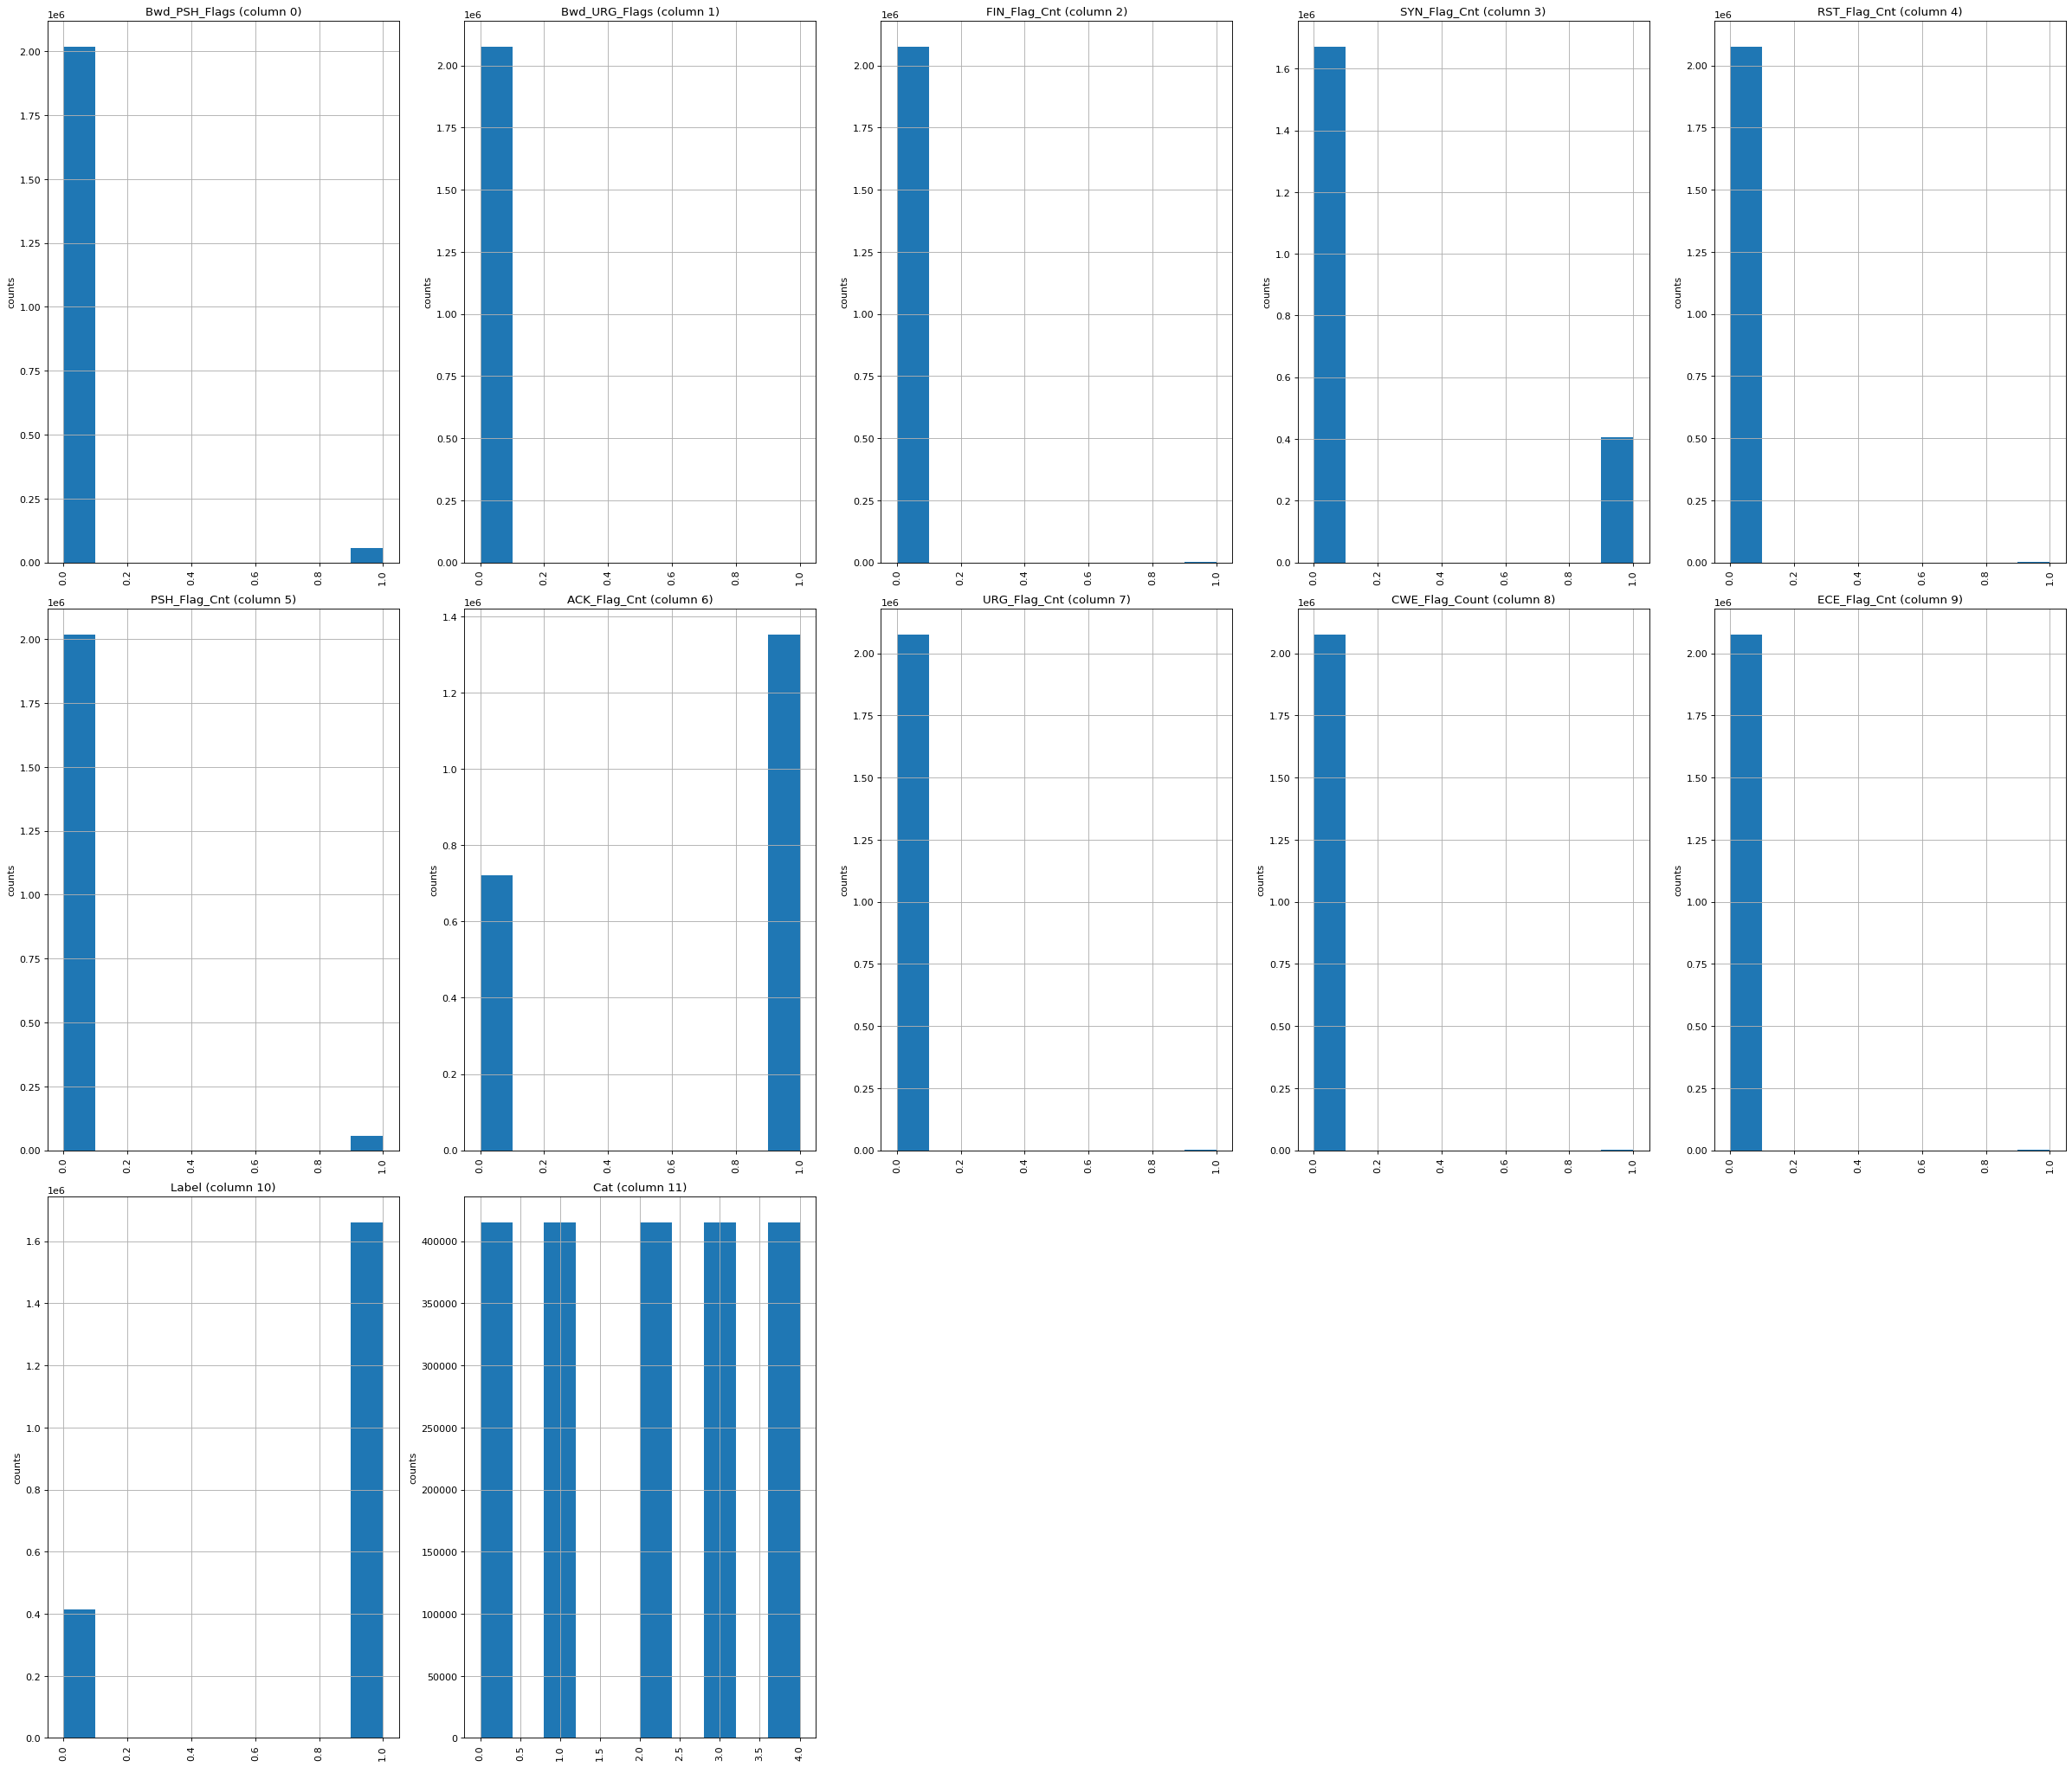

In [ ]:
plotPerColumnDistribution(df, 25, 5)

In [ ]:
df=df.drop(columns=['Fwd_Pkt_Len_Std',
 'Bwd_IAT_Std',
 'Fwd_PSH_Flags',
 'Bwd_PSH_Flags',
 'Fwd_URG_Flags',
 'Bwd_URG_Flags',
 'FIN_Flag_Cnt',
 'SYN_Flag_Cnt',
 'RST_Flag_Cnt',
 'PSH_Flag_Cnt',
 'URG_Flag_Cnt',
 'CWE_Flag_Count',
 'ECE_Flag_Cnt',
 'Fwd_Byts/b_Avg',
 'Fwd_Pkts/b_Avg',
 'Fwd_Blk_Rate_Avg',
 'Bwd_Byts/b_Avg',
 'Bwd_Pkts/b_Avg',
 'Bwd_Blk_Rate_Avg',
 'Init_Fwd_Win_Byts',
 'Fwd_Seg_Size_Min',
 'Active_Mean',
 'Active_Std',
 'Active_Max',
 'Active_Min'])

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):

    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for IoTID20 Train', fontsize=15)
    plt.savefig('2')
    plt.show()

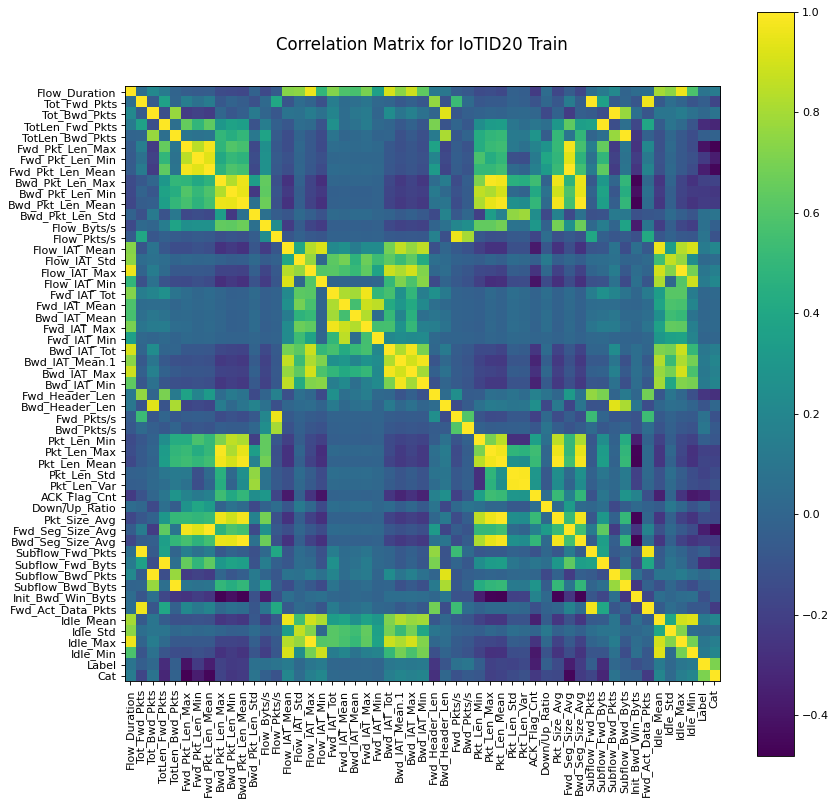

In [ ]:
plotCorrelationMatrix(df, 12)

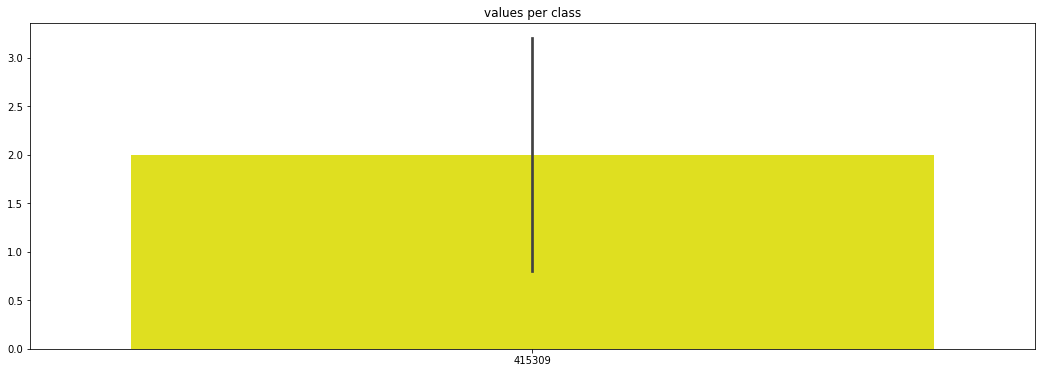

In [ ]:
label_counts = df['Cat'].value_counts()
plt.figure(figsize=(18,6));
sns.barplot(y=label_counts.index, x=label_counts.values, color='Yellow');
plt.title('values per class');
plt.savefig('3')
# display(label_counts)

In [ ]:
normalized_df = (df-df.min())/(df.max()-df.min())
normalized_df = normalized_df.dropna()

In [ ]:
tmp = normalized_df.pop('Cat')

In [ ]:
normalized_df

,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,...,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,0.000740,0.005376,0.000000,0.008940,0.001849,0.670765,0.670765,0.670765,0.976776,0.979452,...,0.008940,0.000000,0.001849,0.000000,0.005376,0.000750,0.000000,0.000750,0.000750,1.0
1,0.053099,0.005376,0.001789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001789,0.000000,0.222794,0.000000,0.026557,0.033715,0.042551,0.010563,1.0
2,0.001400,0.000000,0.003578,0.000000,0.003629,0.000000,0.000000,0.000000,0.948087,0.020548,...,0.000000,0.003578,0.003629,0.028534,0.000000,0.000705,0.000011,0.000710,0.000700,1.0
3,0.001500,0.000000,0.001789,0.000000,0.003590,0.000000,0.000000,0.000000,0.948087,0.950685,...,0.000000,0.001789,0.003590,0.028534,0.000000,0.001510,0.000000,0.001510,0.001510,1.0
4,0.001520,0.010753,0.000000,0.008066,0.000543,0.308743,0.296448,0.302596,0.286885,0.287671,...,0.008066,0.000000,0.000543,0.000000,0.010753,0.000765,0.000011,0.000770,0.000760,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076540,0.001310,0.000000,0.001789,0.000000,0.003590,0.000000,0.000000,0.000000,0.948087,0.950685,...,0.000000,0.001789,0.003590,0.028534,0.000000,0.001320,0.000000,0.001320,0.001320,1.0
2076541,0.001170,0.005376,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.496002,0.000000,0.001180,0.000000,0.001180,0.001180,1.0
2076542,0.001200,0.000000,0.001789,0.000000,0.001834,0.000000,0.000000,0.000000,0.948087,0.020548,...,0.000000,0.001789,0.001834,0.028534,0.000000,0.001210,0.000000,0.001210,0.001210,1.0
2076543,0.001140,0.000000,0.001789,0.000000,0.003745,0.000000,0.000000,0.000000,0.989071,0.991781,...,0.000000,0.001789,0.003745,0.002380,0.000000,0.001150,0.000000,0.001150,0.001150,1.0


In [ ]:
tmp.value_counts()

0.25    415309
0.75    415309
0.50    415309
0.00    415309
1.00    415309
Name: Cat, dtype: int64

In [ ]:
tmp.isnull().values.any()

False

In [ ]:
y_train=tmp
y_train

0          0.25
1          0.75
2          0.50
3          0.25
4          0.25
           ... 
2076540    1.00
2076541    1.00
2076542    1.00
2076543    1.00
2076544    1.00
Name: Cat, Length: 2076545, dtype: float64

In [ ]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=122, padding="same",activation="relu",input_shape=(52, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape = (128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
for layer in model.layers:
    print(layer.output_shape)

(None, 52, 64)
(None, 10, 64)
(None, 10, 64)
(None, 128)
(None, 128, 1)
(None, 25, 1)
(None, 25, 1)
(None, 256)
(None, 256)
(None, 5)
(None, 5)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 64)            7872      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 64)           256       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                        

In [ ]:
oos_pred = []
k_dict = {'accuracy' : [], 'detectionRate' : [], 'falsepositiverate' : [], 'confusionmatrix' : []}

In [ ]:
features = normalized_df.to_numpy()
labels = tmp.to_numpy()

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(features, labels, test_size=0.2, random_state=1)

In [ ]:
for k in range(2,11,2):
    k_dict['accuracy'].append([])
    k_dict['confusionmatrix'].append([])
    kfold = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    kfold.get_n_splits(normalized_df,y_train)

    x_train_1=np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

    dummies = pd.get_dummies(train_Y)
    outcomes = dummies.columns
    num_classes = len(outcomes)
    y_train_1 = dummies.values

    x_test_2=np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

    dummies_test = pd.get_dummies(test_Y)
    outcomes_test = dummies_test.columns
    num_classes = len(outcomes_test)
    y_test_2 = dummies_test.values


In [ ]:

    model.fit(x_train_1, y_train_1, batch_size=256, validation_data=(x_test_2,y_test_2), epochs=5)

    pred = model.predict(x_test_2)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(y_test_2,axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    k_dict['accuracy'][-1].append(score)
    cm = confusion_matrix(y_eval, pred, labels=[0,1,2,3,4])
    k_dict['confusionmatrix'][-1].append(cm)
    print("Validation score: {}".format(score))


Epoch 1/5
6490/6490 [==============================] - 120s 16ms/step - loss: 0.3765 - accuracy: 0.8423 - val_loss: 0.3362 - val_accuracy: 0.8611
Epoch 2/5
6490/6490 [==============================] - 104s 16ms/step - loss: 0.3398 - accuracy: 0.8601 - val_loss: 0.3324 - val_accuracy: 0.8628
Epoch 3/5
6490/6490 [==============================] - 103s 16ms/step - loss: 0.3321 - accuracy: 0.8639 - val_loss: 0.3293 - val_accuracy: 0.8656
Epoch 4/5
6490/6490 [==============================] - 105s 16ms/step - loss: 0.3249 - accuracy: 0.8671 - val_loss: 0.3134 - val_accuracy: 0.8710
Epoch 5/5
12979/12979 [==============================] - 68s 5ms/step
Validation score: 0.8698487150531291


In [ ]:
accuracy = []
for k_acc in k_dict['accuracy']:
    accuracy.append(max(k_acc))

ValueError: ignored

In [ ]:
f1_scores = []
for k_mat in k_dict['confusionmatrix']:
    f1_scores.append([])
    for i in range(len(k_mat)):
        f1 = []
        for j in range(5):
            pr = (k_mat[i][j][j])/sum(k_mat[i][j])
            s = 0
            for m in range(5):
                s+=k_mat[i][m][j]
            re = (k_mat[i][j][j])/s
            score = (2 * pr * re)/ (pr + re)
            f1.append(score)
        f1_scores[-1].extend(f1)


class_f1_scores = []
k = 2
for i in range(5):
    class_f1_scores.append([])
    for j in range(5):
        s = sum(f1_scores[i][j::5])
        class_f1_scores[-1].append(s/k)
    k+=2



In [ ]:
false_positive_rate = []
detection_rate = []
for k_mat in k_dict['confusionmatrix']:
    false_positive_rate.append([])
    detection_rate.append([])
    for i in range(len(k_mat)):
        FP = k_mat[i].sum(axis=0) - np.diag(k_mat[i])
        FN = k_mat[i].sum(axis=1) - np.diag(k_mat[i])
        TP = np.diag(k_mat[i])
        TN = k_mat[i].sum() - (FP + FN + TP)

        FPR = sum(FP)/sum(FP+TN)
        DR = sum(TP)/sum(TP + FP)
        false_positive_rate[-1].append(FPR)
        detection_rate[-1].append(DR)

    false_positive_rate[-1] = np.mean(false_positive_rate[-1])*100
    detection_rate[-1] = np.mean(detection_rate[-1])


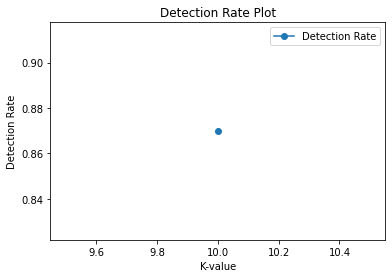

In [ ]:
# Detection Rate Plot
k_vals = [2,4,6,8,10]
plt.figure()
plt.plot(k_vals, detection_rate, marker='o', label = 'Detection Rate')
plt.title('Detection Rate Plot')
plt.xlabel('K-value')
plt.ylabel('Detection Rate')
plt.legend()
plt.savefig('Detection Rate Plot')
plt.show()

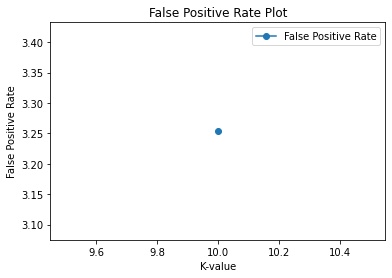

In [ ]:
# False Positive Rate Plot
plt.figure()
plt.plot(k_vals, false_positive_rate, marker='o', label = 'False Positive Rate')
plt.title('False Positive Rate Plot')
plt.xlabel('K-value')
plt.ylabel('False Positive Rate')
plt.legend()
plt.savefig('False Positive Rate Plot')
plt.show()

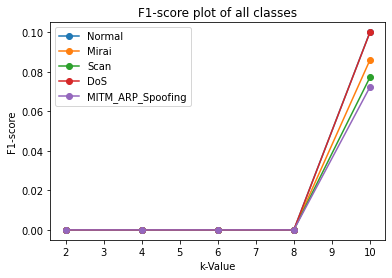

In [ ]:
# F1 Score plot of all classes
Normal, Mirai, Scan, DoS, MITM_ARP_Spoofing = [], [], [], [], []
for i in range(5):
    Normal.append(class_f1_scores[i][0])
    Mirai.append(class_f1_scores[i][1])
    Scan.append(class_f1_scores[i][2])
    DoS.append(class_f1_scores[i][3])
    MITM_ARP_Spoofing.append(class_f1_scores[i][4])

plt.figure()
plt.plot(k_vals, Normal, marker='o', label = 'Normal')
plt.plot(k_vals, Mirai, marker='o', label = 'Mirai')
plt.plot(k_vals, Scan, marker='o', label = 'Scan')
plt.plot(k_vals, DoS, marker='o', label = 'DoS')
plt.plot(k_vals, MITM_ARP_Spoofing, marker='o', label = 'MITM_ARP_Spoofing')
plt.title('F1-score plot of all classes')
plt.xlabel('k-Value')
plt.ylabel('F1-score')
plt.legend()
plt.savefig('F1-score Plot')
plt.show()

In [ ]:
# Confusion Matrix Plot
class_names = ['Normal','Mirai','Scan','DoS','MITM ARP Spoofing']
cmap=plt.cm.Blues
cm = k_dict['confusionmatrix'][4][7]
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j]), ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.savefig('Confusion Matrix')
plt.show()

np.set_printoptions(precision=2)

IndexError: ignored

In [ ]:
# Table of Multiclass Classification Results
d = [['2', accuracy[0], detection_rate[0], false_positive_rate[0]], ['4', accuracy[1], detection_rate[1], false_positive_rate[1]], ['6', accuracy[2], detection_rate[2], false_positive_rate[2]], ['8', accuracy[3], detection_rate[3], false_positive_rate[3]], ['10', accuracy[4], detection_rate[4], false_positive_rate[4]], ['Average', np.mean(accuracy), np.mean(detection_rate), np.mean(false_positive_rate)]]
tab = pd.DataFrame(d,columns = ['K-value','Accuracy%','Detection Rate%','False Positive Rate%'])
tab

IndexError: ignored